In [140]:
import torch as t
from torch import nn
import torchvision 
from torchvision import transforms
import einops
import matplotlib.pyplot as plt
from torch import optim
import torch.nn.functional as F
import random

In [141]:
model = torchvision.models.resnet34(pretrained=True)
model.eval();

In [142]:
def imshow(img, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4:
        img = img.squeeze(0)
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    plt.imshow(img_reshaped.detach())
    plt.xticks([])
    plt.yticks([])

In [143]:
class PixelImage(nn.Module):
    def __init__(self):
        super(PixelImage, self).__init__()
        self.image = nn.Parameter(t.rand((1, 3, 224, 224)))

    def forward(self):
        return t.maximum(t.minimum(self.image, t.Tensor([1.])), t.Tensor([0.]))

In [144]:
def train(image, logit_index, num_iters, lr=0.05):
    logits = []
    optimizer = optim.Adam(image.parameters(), lr)
    for _ in range(num_iters):
        optimizer.zero_grad()
        output = model(image())
        logit = output[0,logit_index]
        logits.append(logit)
        loss = -logit
        loss.backward()
        optimizer.step()
    plt.plot(range(num_iters), logits)
    print(f"Final logit: {model(image())[0,logit_index]}")

Final logit: 179.6903533935547


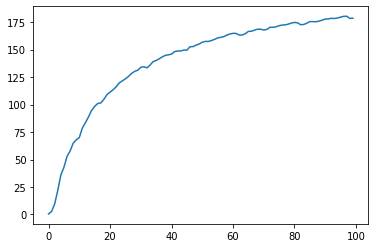

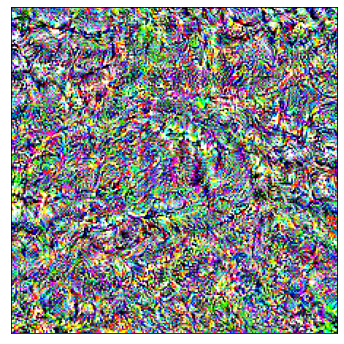

In [145]:
image = PixelImage()
train(image, 50, 100)
imshow(image())

In [146]:
class SigmoidImage(nn.Module):
    def __init__(self):
        super(SigmoidImage, self).__init__()
        self.image = nn.Parameter(t.randn((1, 3, 224, 224)))

    def forward(self):
        return t.sigmoid(self.image)

Final logit: 162.23719787597656


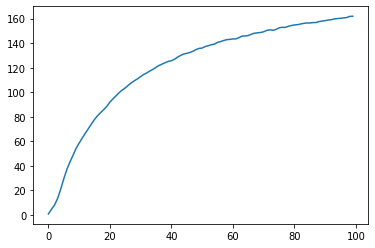

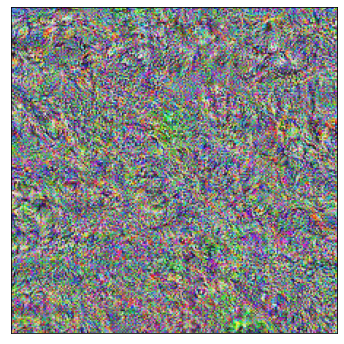

In [147]:
image = SigmoidImage()
train(image, 50, 100)
imshow(image())

In [148]:
def transform_train(image, logit_index, num_iters, lr=0.05, tforms=[]):
    logits = []
    optimizer = optim.Adam(image.parameters(), lr)
    for _ in range(num_iters):
        optimizer.zero_grad()
        transformed_image = transforms.Compose(tforms)(image())
        output = model(transformed_image)
        logit = output[0,logit_index]
        logits.append(logit)
        loss = -logit
        loss.backward()
        optimizer.step()
    plt.plot(range(num_iters), logits)
    print(f"Final logit: {model(image())[0,logit_index]}")

Final logit: 19.973548889160156


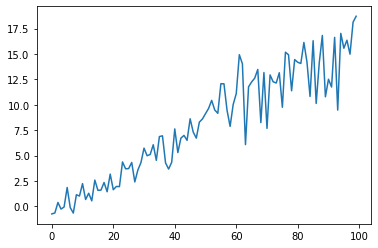

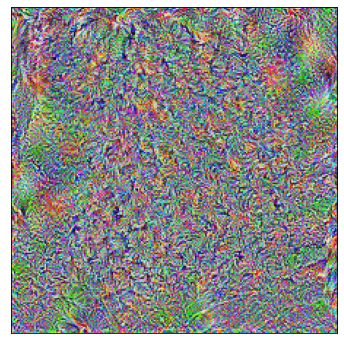

In [149]:
image = SigmoidImage()
tforms = [transforms.ColorJitter(.05, .05, .05, .05), transforms.RandomAffine((-10, 10), (0.03, 0.03), scale=(0.9, 1.1))]
transform_train(image, 10, 100, lr=0.05, tforms=tforms)
imshow(image())

In [150]:
class FourierImage(nn.Module):
    def __init__(self):
        super(FourierImage, self).__init__()
        self.freq_params = nn.Parameter(t.randn((1, 3, 224, 113, 2)))

    def forward(self):
        image = t.fft.irfft2(t.view_as_complex(self.freq_params))
        return t.sigmoid(image)

Final logit: 161.9292755126953


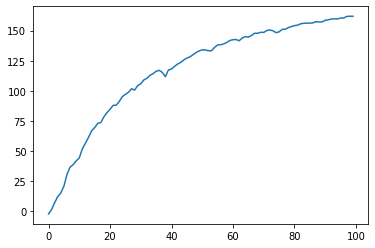

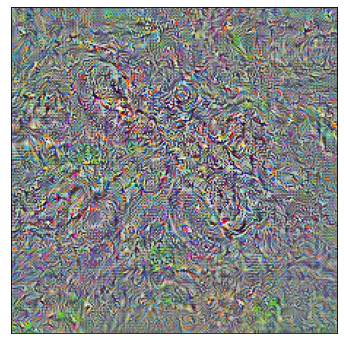

In [151]:
image = FourierImage()
train(image, 50, 100, lr=20)
imshow(image())

In [152]:
class NormalizedFourierImage(nn.Module):
    def __init__(self, height=224, width=113):
        super(NormalizedFourierImage, self).__init__()
        self.amplitudes = nn.Parameter(t.randn((1, 3, height, width, 2)))
        fxs = einops.repeat(t.fft.fftfreq(width), "w -> h w", h=height)
        fys = einops.repeat(t.fft.fftfreq(height), "h -> h w", w=width)
        self.norms = 1 / t.sqrt(fxs**2 + fys**2)
        self.norms[0,0] = height 

    def forward(self):
        image = t.fft.irfft2(self.norms * t.view_as_complex(self.amplitudes))
        return t.sigmoid(image)

Final logit: 50.42867660522461


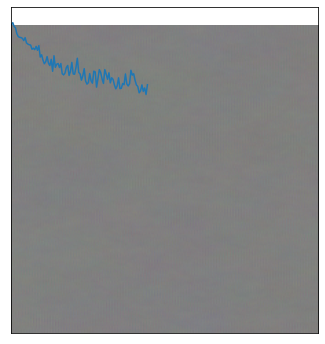

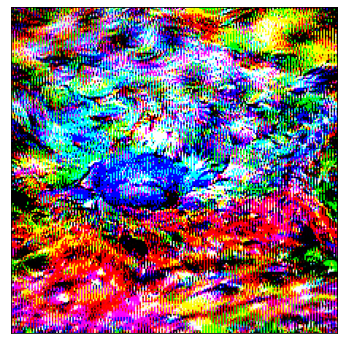

In [153]:
image = NormalizedFourierImage()
imshow(image())
transform_train(image, 20, 100, lr=20, tforms=tforms)
imshow(image())

In [154]:
class DecorrelatedImage(nn.Module):
    def __init__(self, width=224, height=224):
        super(DecorrelatedImage, self).__init__()
        self.matrix = t.Tensor([[0.56282854, 0.19482528, 0.0432945],
                                [0.5844758, 0., -0.10823626],
                                [ 0.5844758, -0.19482528, 0.06494176]])
        self.decorrel_params = nn.Parameter(t.randn((1, 3, height, width)))
        self.height = height
        self.width = width

    def forward(self):
        image = t.einsum("b c h w, a c -> b a h w", self.decorrel_params, self.matrix)
        image = (image - image.mean())/image.std()
        return t.sigmoid(image)

Final logit: 149.88404846191406


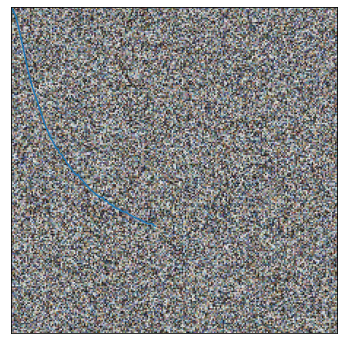

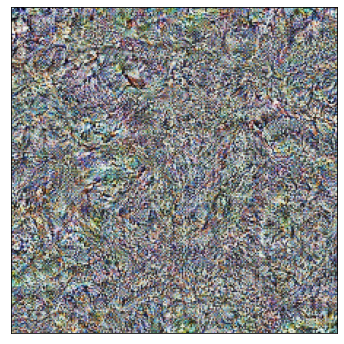

In [155]:
image = DecorrelatedImage()
imshow(image())
train(image, 50, 100)
imshow(image())

In [160]:
class DecorrelatedFourierImage(nn.Module):
    def __init__(self, height=224, width=113):
        super(DecorrelatedFourierImage, self).__init__()
        self.amplitudes = nn.Parameter(t.randn((1, 3, height, width, 2)))
        fxs = einops.repeat(t.fft.fftfreq(width), "w -> h w", h=height)
        fys = einops.repeat(t.fft.fftfreq(height), "h -> h w", w=width)
        self.norms = 1 / t.sqrt(fxs**2 + fys**2)
        self.norms[0,0] = height
        self.matrix = t.Tensor([[0.56282854, 0.19482528, 0.0432945],
                                [0.5844758, 0., -0.10823626],
                                [ 0.5844758, -0.19482528, 0.06494176]])

    def forward(self):
        decorrel_params = t.fft.irfft2(self.norms * t.view_as_complex(self.amplitudes))
        image = t.einsum("b c h w, a c -> b a h w", decorrel_params, self.matrix)
        image = (image - image.mean())/image.std()
        return t.sigmoid(image)

Final logit: 74.49772644042969


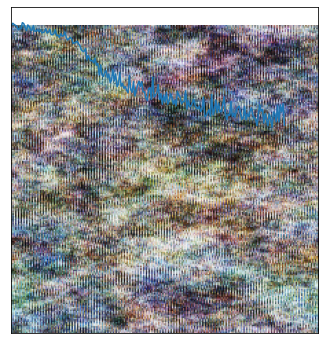

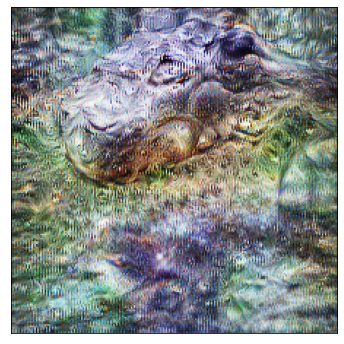

In [161]:
image = DecorrelatedFourierImage()
imshow(image())
transform_train(image, 50, 200, lr=40, tforms=tforms)
imshow(image())